In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv("sonar.csv")

In [ ]:
# Separate features and the target variable
X = data.iloc[:, :-1] # Features (all columns except the last one)
y = data.iloc[:, -1]  # Target variable (lasst column)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
from sklearn.preprocessing import StandardScaler
st_x= StandardScaler()
X_train= st_x.fit_transform(X_train)
X_test= st_x.transform(X_test)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the GBM classifier
gbm = GradientBoostingClassifier()

# Train the GBM model
gbm.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
# Make predictions on the testing set
y_pred = gbm.predict(X_test)

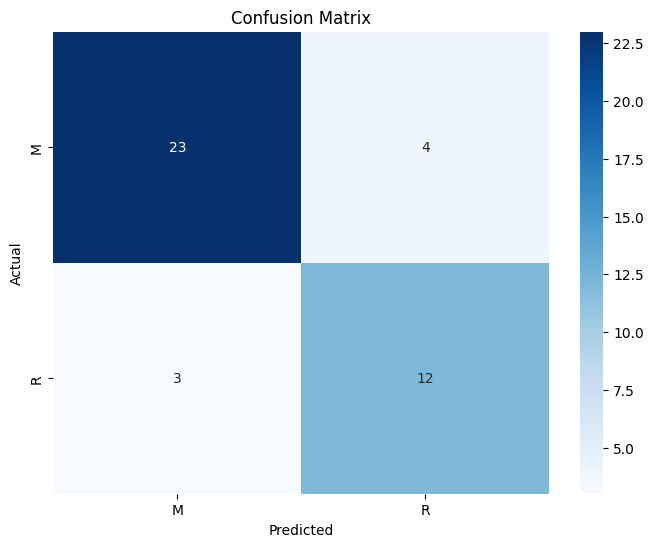

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have already trained and obtained predictions from your LightGBM model

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
labels = ['M', 'R']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='M')
recall = recall_score(y_test, y_pred, pos_label='M')
f1 = f1_score(y_test, y_pred, pos_label='M')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision (Mines):", precision)
print("Recall (Mines):", recall)
print("F1-Score (Mines):", f1)

Accuracy: 0.8333333333333334
Precision (Mines): 0.8846153846153846
Recall (Mines): 0.8518518518518519
F1-Score (Mines): 0.8679245283018868


## GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 4, 5]
}

# Perform grid search
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, refit = True, verbose =2)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Hyperparameters:  {'learning_rate': 1.0, 'max_depth': 3, 'n_estimators': 100}
Best Score:  0.8303030303030303


In [ ]:
y_pred = grid_search.predict(X_test)
grid_predictions = grid_search.predict(X_test)
from sklearn.metrics import classification_report
# print classification report
print(classification_report(y_test, grid_predictions))
print(accuracy_score(y_test, grid_predictions))

              precision    recall  f1-score   support

           M       0.88      0.78      0.82        27
           R       0.67      0.80      0.73        15

    accuracy                           0.79        42
   macro avg       0.77      0.79      0.78        42
weighted avg       0.80      0.79      0.79        42

0.7857142857142857


## Bayesian

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
from skopt import BayesSearchCV
# Define the objective function to optimize
def objective_function(learning_rate, n_estimators, max_depth):
    # Create the gradient boosting classifier with the hyperparameters
    model = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=int(n_estimators), max_depth=int(max_depth))

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Calculate and return the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Define the search space for hyperparameters
pbounds = {'learning_rate': (0.01, 0.1),
           'n_estimators': (100, 300),
           'max_depth': (3, 5)}

# Perform Bayesian optimization
optimizer = BayesSearchCV(estimator=gbm, search_spaces=param_grid, n_iter=50, cv=5, random_state=42)
optimizer.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", optimizer.best_params_)
print("Best Score: ",optimizer.best_score_)

Best Hyperparameters:  OrderedDict([('learning_rate', 1.0), ('max_depth', 3), ('n_estimators', 300)])
Best Score:  0.8303030303030303


In [ ]:
y_pred = optimizer.predict(X_test)
bayes_predictions = optimizer.predict(X_test)
from sklearn.metrics import classification_report
# print classification report
print(classification_report(y_test, bayes_predictions))
print(accuracy_score(y_test, bayes_predictions))

              precision    recall  f1-score   support

           M       0.87      0.74      0.80        27
           R       0.63      0.80      0.71        15

    accuracy                           0.76        42
   macro avg       0.75      0.77      0.75        42
weighted avg       0.78      0.76      0.77        42

0.7619047619047619


## Tree-structured Parzen Estimators

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from hyperopt import hp, tpe, fmin, Trials

# Generate a synthetic dataset for classification
X, y = make_classification(n_samples=1000, random_state=42)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function to minimize
def objective(params):
    learning_rate = params['learning_rate']
    n_estimators = params['n_estimators']
    max_depth = params['max_depth']

    model = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)

    accuracy = model.score(X_test, y_test)
    return {
        'loss': -accuracy,
        'status': 'ok',
        'accuracy': accuracy
    }

# Define the search space for hyperparameters
space = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.choice('n_estimators', range(100, 301, 50)),
    'max_depth': hp.choice('max_depth', range(3, 6))
}

# Perform hyperparameter tuning with TPE
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best hyperparameters and accuracy
print("Best Hyperparameters: ", best)
best_trial = trials.best_trial
print("Best Accuracy: ", -best_trial['result']['loss'])


100%|██████████| 50/50 [01:09<00:00,  1.39s/trial, best loss: -0.915]
Best Hyperparameters:  {'learning_rate': 0.27979652113244347, 'max_depth': 2, 'n_estimators': 1}
Best Accuracy:  0.915


## Simulated Annealing

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from scipy.optimize import basinhopping

# Generate a synthetic dataset for classification
X, y = make_classification(n_samples=1000, random_state=42)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function to minimize
def objective(params):
    learning_rate = params[0]
    n_estimators = int(params[1])
    max_depth = int(params[2])

    model = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)

    accuracy = model.score(X_test, y_test)
    return -accuracy

# Define the bounds for hyperparameters
bounds = [(0.001, 0.1), (100, 300), (3, 5)]

# Perform hyperparameter tuning with Simulated Annealing
result = basinhopping(func=objective, x0=[0.01, 150, 4], minimizer_kwargs={"bounds": bounds})

# Print the best hyperparameters and accuracy
best_params = result.x
best_accuracy = -result.fun
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_accuracy)


Best Hyperparameters:  [9.99999979e-02 1.49702927e+02 3.00000004e+00]
Best Accuracy:  0.91
